Classification - Comparison of Binary Classifiers

Name: Darren King
Student_ID: 17145031

In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
import pickle

## Exploratory Data Analysis

In [708]:
df = pd.read_csv("seeds.csv")

In [709]:
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


We have 7 *predictor* or independent variable attributes which lead to a dependent variable or target for classification, namely one of three different types of wheat: Kama, Rosa, Canadian

In [710]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [711]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [712]:
# Do we have any missing values?
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

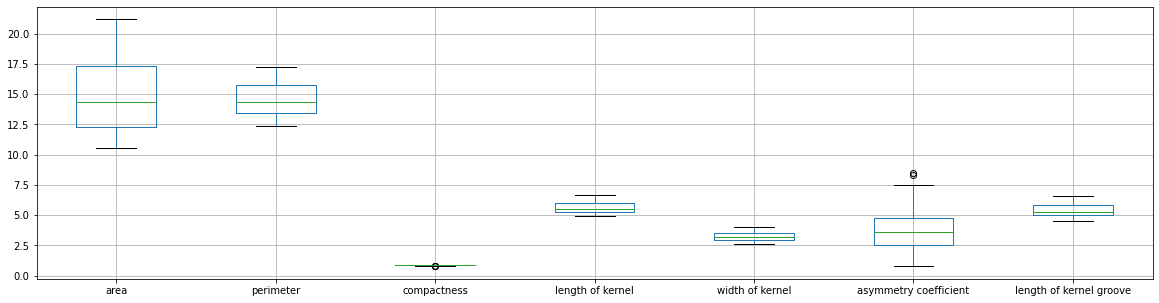

In [713]:
# Do we have any outliers? An outlier is an observation point that is distant from other observations - a boxplot is one of the most effective means of visualising outliers.
# If we consider anything outside the highest and lowest values as depicted by boxplot as outliers.... what we define as outliers is somewhat subjective; we could argue outliers
# as anything outside the IQR in which case we would have to take a different approach, but I argue it's not unreasonable to adopt this approach.

df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The asymmetry coefficient has the most notable/prominent outliers. We could look at this further to characterise mild and extreme outliers, but for now I am just considering extreme outliers, in which case we can see such outliers in the asymmetry coefficient.

## Data Preparation

We're exploring binary classification but our dependent/target variable has 3 possibilities, namely {1,2,3}  so let's have our type 1 seed as is and classify our type 2 and 3 seed as 0. So our seeds are either type 1 {1} or not type 1 {0}.

In [714]:
mapper = {1:1, 2:0, 3:0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

We can clearly see that our dataset is now skewed; the majority of our data items are classed as type 0 - this will affect our metrics later as the model will likely overfit to the class that's represented more.
We can resample on the training set. See below for the use of SMOTE to deal with this imbalance.

We need to deal with the outliers in the 'asymmetry coefficient' attribute, and then we need to scale all of our data.

In [715]:
# These are all the names of the independent variables
names_all = [c for c in df if c not in ['type']]

# These are the names of the independent variables with prominent outliers
names_outliers = ['asymmetry coefficient']

# These are the names of the independent variables without prominent outliers
names_no_outliers = list(set(names_all) - set(names_outliers))

In [716]:
print(names_all)
print(names_outliers)
print(names_no_outliers)

['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove']
['asymmetry coefficient']
['width of kernel', 'perimeter', 'length of kernel groove', 'length of kernel', 'compactness', 'area']


In [717]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    """
    A class to be used in the preprocessing pipeline to put the names of the columns/attributes back
    as we will lose the names of the columns in the train/test split
    We're subclassing from the BaseEstimator and the TransformerMixin to ensure we inherit everything from
    these classes
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [718]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    A class to select a particular group of columns as we won't be preprocessing all the columns in
    the same manner
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Now for the preprocessing pipeline:

In [719]:
# In this pipeline we're using multiple transformer objects, namely the outlier_columns and no_outlier_columns to apply a different
# pipeline to the relevant columns of our data - we could do these steps in isolation, but we want to pipeline our process.
# We're then using the scikit learn FeatureUnion which concatenates the results of the transformers


preprocess_pipeline = make_pipeline(
    AddColumnNames(names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(names_no_outliers),
            StandardScaler()
        ))
    ])
)

And split the data...

In [720]:
y = df['type']
X = df.drop('type', axis=1).values

In [721]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42, stratify=y)

In [722]:
print(X_train.shape, y_train.shape)

(157, 7) (157,)


In [723]:
# We can use the SMOTE package to over_sample our data to give us enough synthetic data to be balanced
# SMOTE = Synthetic Minority Over Sampling Technique

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)

(210, 7) (210,)


We can see from the printed shape of the arrays before and after synthetic oversampling that the SMOTE class has worked on the imbalance. Equally, only use SMOTE on the training sets, not the test sets; we only need to train our model properly, regardless of what is in the test set if the model is trained correctly it should be able to deal with any reasonable test.

## Grid Search for Best Parameters of Classifiers - Support Vector Machine and Random Forest

In [724]:
# Create the pipeline using a Support Vector Machine Classifier
# We call on the pre-process pipeline that we created above, followed by an SVM

my_pipeline = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True, random_state=42))], verbose=True)

# Now a parameter grid to search for the best parameters as a dictionary

param_grid = {
    'svm__C': [0.1,1,10,100,110],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

search = GridSearchCV(my_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)

print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)
# print("Best Estimator: ", search.best_estimator_) - can be useful to see exactly the steps of the pipeline for the best estimator

# We need to store the parameters and the best model for later use in our comparison
svm_best_cv_score = search.best_score_
svm_best_params = search.best_params_
svm_best_model = search.best_estimator_

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svm, total=   0.0s
Best CV Score:  0.9809523809523808
Best Parameters:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


Above we're using GridSearch which is an exhaustive search over the specified values for a given model.
In the case of the SVM above, I've considered 3 hyper-parameters:
1. C - Depending on the noise in our data we can go for a low C to improve regularisation or a higher C to improve fit; it's a trade-off between over-fitting and under-fitting - this value defaults to one, so I've included a value below this for noisy data and a number of values above this but the larger we get with C the longer it will take to train our model as it is effectively over-fitting the data. A low C will give a soft margin, a high C will give a hard margin.
2. Gamma
3. The Kernel - The choice of kernel facilitates the kernel trick whereby you can get the same result from your model as if you added multiple polynomial features without having the overhead such a high degree polynomial would carry.

In [725]:
# Now create a pipeline using a Random Forest Classifier
# Again we call on the pre-process pipeline created above

my_pipeline = Pipeline(steps=[('preprocess', preprocess_pipeline),('random_forest', RandomForestClassifier())])

# Now a parameter grid to search for the best parameters as a dictionary

param_grid = {
    'random_forest__n_estimators': [10,20,30,40,50,60,70,80,90,100],  # The number of trees in the forest
    'random_forest__max_depth': [2,4,6,8,10]  # The maximum depth of the tree
}

search = GridSearchCV(my_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)

print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

rf_best_cv_score = search.best_score_
rf_best_params = search.best_params_
rf_best_model = search.best_estimator_


Best CV Score:  0.9476190476190476
Best Parameters:  {'random_forest__max_depth': 10, 'random_forest__n_estimators': 20}


For the Random Forest Classifier above which is effectively a large number of decision trees we're looking at 2 hyper-parameters:
1. n_estimators: The number of trees in the forest. Logically, the more trees, the more likely the model will classify on the test set correctly as the trees protect each other from their individual errors.
2. max_depth: As the name suggests, the number of branches/depth of each tree in our forest.

By not using a max_samples or bootstrapping we're training each tree on the whole dataset - we could add these as GridSearch hyper-parameters.

## Comparison of Classifiers using Test Set

In [726]:
mean_fpr = np.linspace(start=0, stop=1, num=100) # returns evenly spaced numbers over a specified interval
# In order to plot ROC curves for the models we need to ensure that we use the same FPR under all curves

In [727]:
def evaluate_model(X_test, y_test, model):
    """
    This function evaluates the accuracy, precision, recall, F1-score, TPR and AUC of a given binary classifier
    :param X_test: Our independent/predictor variable test data
    :param y_test: Our dependent variable test data
    :param model: A trained binary classifier
    :return: Accuracy, Precision, Recall, F1 Score, TPR and AUC (Area under ROC Curve)
    """

    _probabilities = model.predict_proba(X_test)[:,1] # probabilistic predictions for the evaluation set

    _predicted_values = model.predict(X_test)

    _accuracy = accuracy_score(y_test, _predicted_values)

    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    # The label = 1 is the precision, recall and f1 score for the model detecting type 1 seeds

    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    _tpr_transformed = np.array(np.interp(mean_fpr, _fpr, _tpr)) # Compute true positive rates for the values in the mean_fpr array

    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc


In [728]:
svm_accuracy, svm_precision, svm_recall, svm_f1_score, svm_tpr, svm_auc = evaluate_model(X_test, y_test, svm_best_model)

In [729]:
rf_accuracy, rf_precision, rf_recall, rf_f1_score, rf_tpr, rf_auc = evaluate_model(X_test, y_test, rf_best_model)

#### Plotting the Results

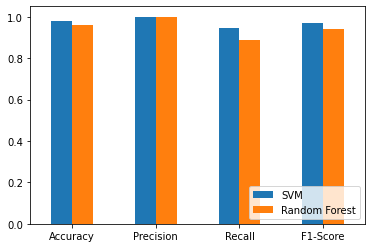

In [730]:
svm_metrics = np.array([svm_accuracy, svm_precision, svm_recall, svm_f1_score])
rf_metrics = np.array([rf_accuracy, rf_precision, rf_recall, rf_f1_score])
index = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_metrics = pd.DataFrame({'SVM': svm_metrics, 'Random Forest': rf_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

When we're measuring the accuracy of a classifier we classically use the following:

1. Accuracy - The ratio or percentage of correct predictions. This isn't a great measure, especially given our dataset is skewed as we have twice as many 0 as 1's, i.e. one of our classes occurs more frequently than the other. However, we corrected that using SMOTE so the accuracy of our accuracy metric is improved.
2. Precision
3. Recall
4. F1-Score

## Train a 3rd Classifier

We can compare the above SVM and Random Forest to other classifiers - let's use a Multi-Layer Perceptron Classifier

In [731]:
my_pipeline = Pipeline(steps=[('preprocess', preprocess_pipeline), ('MLPC', MLPClassifier())])

# Again, we'll use a parameter grid to search for the best parameters as a dictionary

param_grid = {
    'MLPC__activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'MLPC__solver' : ['lbfgs', 'sgd', 'adam'],
    'MLPC__alpha':[0.0001, 0.001, 0.01], # L2 regularisation
    'MLPC__hidden_layer_sizes':[(5,5,5),(10,10,10),(100,100,100)],
    'MLPC__max_iter':[100,150,200,250]
}

search = GridSearchCV(my_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)

print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

mlpc_best_cv_score = search.best_score_
mlpc_best_params = search.best_params_
mlpc_best_model = search.best_estimator_

/Users/darrenking/miniforge3/envs/env_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/darrenking/miniforge3/envs/env_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/darrenking/miniforge3/envs/env_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/darrenking/miniforge3/envs/env_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't 

Best CV Score:  0.9809523809523808
Best Parameters:  {'MLPC__activation': 'tanh', 'MLPC__alpha': 0.0001, 'MLPC__hidden_layer_sizes': (5, 5, 5), 'MLPC__max_iter': 150, 'MLPC__solver': 'lbfgs'}


/Users/darrenking/miniforge3/envs/env_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


When we look at the hyper-parameters for a multi-layer perceptron classifier, there are an array of options that we need to consider. Taking into account the ones that I looked at above:
1. The activation function

Now we can compare this model against our other models using the previously defined evaluate_model function

In [732]:
mlpc_accuracy, mlpc_precision, mlpc_recall, mlpc_f1_score, mlpc_tpr, mlpc_auc = evaluate_model(X_test, y_test, mlpc_best_model)

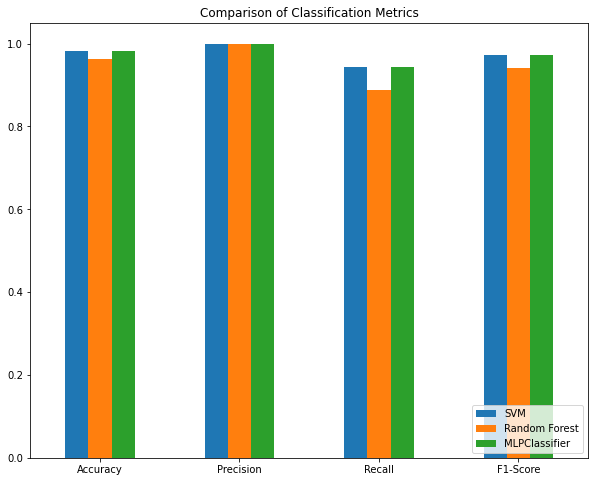

In [733]:
svm_metrics = np.array([svm_accuracy, svm_precision, svm_recall, svm_f1_score])
rf_metrics = np.array([rf_accuracy, rf_precision, rf_recall, rf_f1_score])
mlpc_metrics = np.array([mlpc_accuracy, mlpc_precision, mlpc_recall, mlpc_f1_score])
index = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_metrics = pd.DataFrame({'SVM': svm_metrics, 'Random Forest': rf_metrics, 'MLPClassifier': mlpc_metrics}, index=index)
df_metrics.plot.bar(title="Comparison of Classification Metrics", rot=0, figsize=(10,8))
plt.legend(loc="lower right")
# plt.savefig('classification_metrics_no_smote.png')
plt.show()

What I found is that by balancing the test data, i.e. removing the skew with SMOTE, it improved the metrics of the classifiers, specifically the Random Forest classifier. You can look at the comparison of the classification metrics without balancing the skewed data in the saved attachment (classification_metrics_no_smote.png)